In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import boto3
import io
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
import re

The dataset comes from *Open Food Facts* and was downloaded from: https://www.kaggle.com/openfoodfacts/world-food-facts/home.
'Open Food Facts is a free, open, collbarative database of food products from around the world, with ingredients, allergens, nutrition facts and all the tidbits of information we can find on product labels. Open Food Facts is a non-profit association of volunteers.' Over 5,000 contributors 'have added 100 000+ products from 150 countries using our Android, iPhone or Windows Phone app or their camera to scan barcodes and upload pictures of products and their labels.'

# DATA UPLOAD

food = pd.read_csv(r'/Users/admin/Documents/food.tsv', delimiter = '\t', encoding='ISO-8859-1')

In [2]:
#s3 data

s3 = boto3.client('s3') 
obj = s3.get_object(Bucket='innawendell', Key='food.tsv') 
food = pd.read_csv(io.BytesIO(obj['Body'].read()), delimiter = '\t', encoding='ISO-8859-1')

In [3]:
food.shape

(356027, 163)

In [4]:
food.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-estimate_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=163)

In [5]:
pd.set_option('display.max_columns', 500)
food.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,main_category,main_category_en,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blÃ© noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","To be completed,Nutrition facts to be complete...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,United States,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,Na

# Initial Decision: The Scope of Analysis

During a series of original runs we discovered that our analysis could benefit from inclusion of food categories and serving size into features. Therefore, the original dataset will be reduced to include only the rows that have these data. 


Additionally, we found out that countries of purchase are disproportionally represented in the dataset: France and the US are most common. However, ingredients were listed in multiple languages which could lead to duplicates and confusion. Therefore, decision was made to narrow down the scope to the US only. 

# Selecting Retail Country: US

For our analysis, we will only focus on food that is on the market in the US.

In [6]:
food['countries'].value_counts().head(20)

US                169789
France            106296
en:FR              16056
Suisse             12003
Deutschland         6900
EspaÃ±a             3896
United Kingdom      3363
United States       2358
en:CH               2207
en:BE               1759
en:GB               1647
en:FR,France        1483
Australia           1483
Ð Ð¾ÑÑÐ¸Ñ        1377
en:ES               1104
en:DE               1093
en:US                909
Belgique             830
en:AU                714
en:IT                660
Name: countries, dtype: int64

In [7]:
food_abbr = food[food['countries'].isin(['US', 'United States', 'en:US'])]

In [8]:
food_abbr.shape

(173056, 163)

## Selecting Features and The Target Variable (Energy Value per 100 g)

In [9]:
food_abbr.shape

(173056, 163)

In [10]:
features_energy = food_abbr.loc[:, ['ingredients_text', 'energy_100g', 'pnns_groups_2', 'serving_size']]

In [11]:
features_energy = features_energy.dropna(how='any')

In [12]:
#verify that all the nan values were excluded
features_energy.isnull().sum()

ingredients_text    0
energy_100g         0
pnns_groups_2       0
serving_size        0
dtype: int64

In [13]:
features_energy.head(20)

,ingredients_text,energy_100g,pnns_groups_2,serving_size
315,"Unpeeled potatoes, sunflower oil, sea salt.",2243.0,unknown,28 g (1 oz)
496,"Sea clams, sea clam juice, potatoes, wheat flo...",276.0,One-dish meals,122 g (0.5 cup)
608,"COOKED ELBOW MACARONI (WATER, ENRICHED SEMOLIN...",761.0,One-dish meals,198 g
715,"Onion, spices (black pepper, celery seed, caye...",0.0,unknown,0.6 g (0.25 tsp)
770,"Wheat flour, vegetable shortening (partially h...",2230.0,Biscuits and cakes,4 cookies (15g)
951,"Mango puree, water, cane sugar, lemon juice, p...",435.0,unknown,1/2 cup (96g)
952,"Organic tomato puree, organic diced tomatoes, ...",162.0,Dressings and sauces,1/2 cup (116g)
964,Honey,1197.0,unknown,21 g (1 Tbsp)
1024,"CUCUMBERS, WATER, VINEGAR, SALT, CALCIUM CHLOR...",75.0,unknown,1 oz (28 g)
1070,"CUCUMBERS, WATER, VINEGAR, SALT, CALCIUM CHLOR...",21.0,unknown,1/4 pickle (28 g)


In [14]:
#fix alternative capitalization of the category
features_energy.loc[features_energy['pnns_groups_2']=='vegetables'] ='Vegetables'                     

In [15]:
features_energy['pnns_groups_2'].value_counts()

unknown                             690
Dressings and sauces                406
Fruit juices                        208
Bread                               172
Non-sugared beverages               108
Sweetened beverages                  89
Cereals                              79
Milk and yogurt                      76
Biscuits and cakes                   59
Appetizers                           55
Sweets                               47
Chocolate products                   43
Artificially sweetened beverages     35
Breakfast cereals                    33
Cheese                               28
Legumes                              28
Fats                                 25
Vegetables                           18
Fish and seafood                     14
Processed meat                       13
One-dish meals                       13
Meat                                 11
Nuts                                  9
Fruits                                8
Ice cream                             5


# Regex

In [16]:
mls = []
pattern = re.compile(r'\d+\s([m][l])')
pattern_two = re.compile(r'\d+\s([m][L])')
pattern_three = re.compile(r'\d+\s([g])')
pattern_four = re.compile(r'\d+\S([g])')

for entry in features_energy['serving_size']:
    try:
        mls.append(pattern.match(entry).group())
    except AttributeError:
        mls.append(0)


In [17]:
mLs= []
for entry in features_energy['serving_size']:
    try:
        mLs.append(pattern_two.match(entry).group())
    except AttributeError:
        mLs.append(0)

In [18]:
gspace =[]
for entry in features_energy['serving_size']:
    try:
        gspace.append(pattern_three.match(entry).group())
    except AttributeError:
        gspace.append(0)

In [19]:
g_no_space = []
for entry in features_energy['serving_size']:
    try:
        g_no_space.append(pattern_four.match(entry).group())
    except AttributeError:
        g_no_space.append(0)

In [20]:
# matches decimals
pattern_five = re.compile(r'\d+(\.\d{1,2})\s([g])')
gr_dec = []

for entry in features_energy['serving_size']:
    try:
        gr_dec.append(pattern_five.match(entry).group())
    except AttributeError:
        gr_dec.append(0)

In [21]:
features_energy['ml'] = mls
features_energy['mL'] = mLs
features_energy['gram_space'] = gspace 
features_energy['gram_no_space'] = g_no_space
features_energy['gram_decimal'] = gr_dec

In [22]:
#write a transformation function for all rows
def transform(row):
    if row['ml'] != 0:
        return row['ml']
    elif row['mL'] != 0:
        return row['mL']
    elif row['gram_space'] !=0:
        return row['gram_space']
    elif row['gram_no_space'] !=0:
        return row['gram_no_space']
    elif row['gram_decimal'] !=0:
           return row['gram_decimal']
    else:
        return 0

In [23]:
features_energy['serving'] = features_energy.apply(transform, axis=1) 

In [24]:
features_energy.head(3)

,ingredients_text,energy_100g,pnns_groups_2,serving_size,ml,mL,gram_space,gram_no_space,gram_decimal,serving
315,"Unpeeled potatoes, sunflower oil, sea salt.",2243,unknown,28 g (1 oz),0,0,28 g,0,0,28 g
496,"Sea clams, sea clam juice, potatoes, wheat flo...",276,One-dish meals,122 g (0.5 cup),0,0,122 g,0,0,122 g
608,"COOKED ELBOW MACARONI (WATER, ENRICHED SEMOLIN...",761,One-dish meals,198 g,0,0,198 g,0,0,198 g


In [25]:
features_energy_serving = features_energy.drop(['serving_size', 'ml', 'mL', 'gram_space', 'gram_no_space', 'gram_decimal'], axis=1)

In [26]:
features_energy_serving.head()

,ingredients_text,energy_100g,pnns_groups_2,serving
315,"Unpeeled potatoes, sunflower oil, sea salt.",2243,unknown,28 g
496,"Sea clams, sea clam juice, potatoes, wheat flo...",276,One-dish meals,122 g
608,"COOKED ELBOW MACARONI (WATER, ENRICHED SEMOLIN...",761,One-dish meals,198 g
715,"Onion, spices (black pepper, celery seed, caye...",0,unknown,0.6 g
770,"Wheat flour, vegetable shortening (partially h...",2230,Biscuits and cakes,0


In [27]:
features_energy_serving_cleaned = features_energy_serving[features_energy_serving['serving'] !=0]

In [28]:
#check how many entries we have remaining
features_energy_serving_cleaned.shape

(1685, 4)

In [29]:
#grams function
def parse_rows(row):
    if row['serving'].count('g') >0:
        return 1
    else:
        return 0

In [30]:
#mls function
def parse_rows_ml(row):
    if row['serving'].count('g') >0:
        return 0
    else:
        return 1

In [31]:
features_energy_serving_cleaned['grams'] = features_energy_serving_cleaned.apply(parse_rows, axis=1) 

In [32]:
features_energy_serving_cleaned['mls'] = features_energy_serving_cleaned.apply(parse_rows_ml, axis=1) 

In [33]:
def replace(row):
    if row['serving'].count('g') >0:
        return row['serving'].replace('g','')
    elif row['serving'].count('ml') >0:
        return row['serving'].replace('ml', '')
    elif row['serving'].count('mL') >0:
        return row['serving'].replace('mL', '')

In [34]:
# getting rid of the mls or g in the serving column since we creating binary features for grams and mls
features_energy_serving_cleaned['serving'] = features_energy_serving_cleaned.apply(replace, axis=1) 

In [35]:
features_energy_serving_cleaned.head(10)

,ingredients_text,energy_100g,pnns_groups_2,serving,grams,mls
315,"Unpeeled potatoes, sunflower oil, sea salt.",2243,unknown,28,1,0
496,"Sea clams, sea clam juice, potatoes, wheat flo...",276,One-dish meals,122,1,0
608,"COOKED ELBOW MACARONI (WATER, ENRICHED SEMOLIN...",761,One-dish meals,198,1,0
715,"Onion, spices (black pepper, celery seed, caye...",0,unknown,0.6,1,0
964,Honey,1197,unknown,21,1,0
1398,"Sun dried roma tomatoes, pure olive oil, garli...",1540,unknown,19,1,0
1665,"Pure water, aloe vera juice (aloe vera pulp, w...",117,Artificially sweetened beverages,500,0,1
1666,"Pure water, aloe vera juice (aloe vera pulp, w...",117,Artificially sweetened beverages,500,0,1
1777,"ENRICHED FLOUR (_WHEAT_ FLOUR, MALTED BARLEY F...",1120,Bread,45,1,0
1778,"Enriched wheat flour (flour, malted barley flo...",1167,Bread,43,1,0


# Conversion of Data Types

In [36]:
features_energy_serving_cleaned.dtypes

ingredients_text    object
energy_100g         object
pnns_groups_2       object
serving             object
grams                int64
mls                  int64
dtype: object

In [37]:
features_energy_serving_cleaned['energy_100g'] = pd.to_numeric(features_energy_serving_cleaned['energy_100g'], errors='coerce')
features_energy_serving_cleaned['serving'] = pd.to_numeric(features_energy_serving_cleaned['serving'], errors='coerce')

In [38]:
features_energy_serving_cleaned.dtypes

ingredients_text     object
energy_100g         float64
pnns_groups_2        object
serving             float64
grams                 int64
mls                   int64
dtype: object

In [39]:
features_energy_serving_cleaned['energy_100g'] = features_energy_serving_cleaned['energy_100g'].astype(int)
features_energy_serving_cleaned['serving'] = features_energy_serving_cleaned['serving'].astype(int)

In [40]:
features_energy_serving_cleaned.dtypes

ingredients_text    object
energy_100g          int64
pnns_groups_2       object
serving              int64
grams                int64
mls                  int64
dtype: object

# Target Variable Distribution

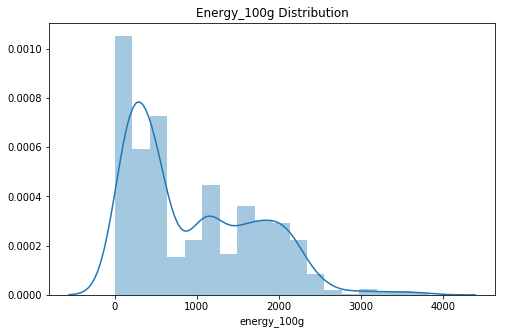

In [41]:
plt.figure(figsize=(8, 5))
sns.distplot(features_energy_serving_cleaned['energy_100g'])
plt.title('Energy_100g Distribution')
plt.show()

# Dummies for Food Categories

In [42]:
cat_dummies = pd.get_dummies(features_energy_serving_cleaned['pnns_groups_2'])

In [43]:
features_energy_concat = pd.concat([features_energy_serving_cleaned, cat_dummies], axis=1, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,copy=True)

In [48]:
features_energy_concat.head()

,ingredients_text,energy_100g,pnns_groups_2,serving,grams,mls,Appetizers,Artificially sweetened beverages,Biscuits and cakes,Bread,Breakfast cereals,Cereals,Cheese,Chocolate products,Dressings and sauces,Dried fruits,Eggs,Fats,Fish and seafood,Fruit juices,Fruits,Ice cream,Legumes,Meat,Milk and yogurt,Non-sugared beverages,Nuts,One-dish meals,Pizza pies and quiche,Processed meat,Sweetened beverages,Sweets,Vegetables,unknown
315,"Unpeeled potatoes, sunflower oil, sea salt.",2243,unknown,28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
496,"Sea clams, sea clam juice, potatoes, wheat flo...",276,One-dish meals,122,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
608,"COOKED ELBOW MACARONI (WATER, ENRICHED SEMOLIN...",761,One-dish meals,198,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
715,"Onion, spices (black pepper, celery seed, caye...",0,unknown,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
964,Honey,1197,unknown,21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Train Test Split

In [45]:
y=features_energy_concat[ 'energy_100g']

In [47]:
X = features_energy_concat.drop(['energy_100g', 'pnns_groups_2'], axis=1)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=108)

# Parsing The Ingredients Text

Function to provide the single ingredient items that are frequent

In [50]:
def text_parsing(df, column, frequency):
    #making all word lower case
    lower = []
    for entry in df[column]:
        lower.append(entry.lower())    
    #removing the fullstops from the strings

    no_fullstops = []
    for entry in lower:
        entry = entry.replace('.', '')
        no_fullstops.append(entry)
    
    #splitting strings at commas
    split = []
    for entry in no_fullstops:
        entry = entry.split(',')
        split.append(entry) 
        
    cleaned = []
    for entry in split:
        for item in entry:
            item = item.split("(")
            cleaned.append(item)
    
    cleaned_new = []
    for entry in cleaned:
        for item in entry:
            item= item.strip(')')
            cleaned_new.append(item)
    cleaned_newer = []
    for entry in cleaned_new:
        if entry.count('[') >0:
            entry = entry.split('[') 
            cleaned_newer.append(entry)
        else:
            cleaned_newer.append(entry)
            
    cleaned_newer_one = []
    for entry in cleaned_newer:
        if entry.count('and/or') >0:
            entry = entry.split('and/or')
            cleaned_newer_one.append(entry)
        else:
            cleaned_newer_one.append(entry)
    unique_words = {}
    for entry in cleaned_newer_one:
        if type(entry) == list:
            for word in entry:
                if word.strip() not in unique_words:
                    unique_words[word.strip()] = 1
            else:   
                unique_words[word.strip()] += 1
        else:
            if entry.strip() not in unique_words:
                unique_words[entry.strip()] = 1
            else:
                unique_words[entry.strip()] += 1
    frequent = {key:value for (key,value) in unique_words.items() if value >= frequency}
    return frequent.keys()

In [57]:
vocab = text_parsing(X_train, 'ingredients_text', 1)

In [58]:
len(vocab)

3650

# Creation of New Features: Parsed Ingredients Text

In [59]:
for word in vocab:
    X_train[word] = X_train['ingredients_text'].str.contains(word, case=False, regex=False)    

In [60]:
X_train.head()

,ingredients_text,serving,grams,mls,Appetizers,Artificially sweetened beverages,Biscuits and cakes,Bread,Breakfast cereals,Cereals,Cheese,Chocolate products,Dressings and sauces,Dried fruits,Eggs,Fats,Fish and seafood,Fruit juices,Fruits,Ice cream,Legumes,Meat,Milk and yogurt,Non-sugared beverages,Nuts,One-dish meals,Pizza pies and quiche,Processed meat,Sweetened beverages,Sweets,Vegetables,unknown,organic tomato puree,organic tomato paste,water,organic cane sugar,organic apple cider vinegar contains less than 2% of each of the following: sea salt,spices,organic onion powder,organic garlic powder,_milk_,vitamin d3,california seedless raisins,raisins are mechanically stemmed and may contain an occasional grape stem or wood piece,cultured goat milk,salt,microbial enzymes,enriched wheat flour,flour,malted barley flour,reduced iron,niacin,thiamin mononitrate,vitamin b1],riboflavin,vitamin b2],folic acid,high fructose corn syrup,yeast,soybean oil,wheat gluten,monoglycerides,calcium propionate,pr,durum _wheat_ semolina,_wheat_ flour,_egg_,15%,popcorn,palm oil,butter,milk,natural flavor,color added,tbhq and citric acid,tomato concentrate from red ripe tomatoes,distilled vinegar,corn syrup,spice,onion powder,natural flavoring,whole grain oats*,peanut butter*,peanuts,sugar*,dextrose*,rice*,sunflower oil*,molasses*,maltodextrin*,honey*,malted barley extract*,vanilla extract,vitamin e,mixed tocopherols,cultured pasteurized organic whole milk,pectin,contains live and active cultures: s thermophilus,l bulgaricus,l acidophilus,bifidus,l casei l rhamnosus,ingredients: filtered water,tapioca starch,palm fruit oil,expeller pressed non gmo canola oil,expeller pressed non gmo safflower oil,coconut oil,pea protein isolate,natural vegan flavors,vegetable glycerine,brown rice syrup,sea salt,yeast extract,xanthan gum,lactic acid vegan,for flavori,annatto for color,carrageenan,titanium dioxide ia naturally occurring mineral,vegan enzyme made in a plant free of animal ingredients,egg,soy,and tree nuts excluding i coconut),apple juice concentrate,filtered water,_coconut_ oil,modified corn and potato starch,potato starch,fermented chao tofu,_soybeans_,sesame oil,calcium sulfate,black cracked pepper,oregano,natural flavor and olive extract,antioxidant used as a preservative,chick peas garbanzos,wheat farina,malted barley,calcium carbonate,ferric orthophosphate,iron,niacinamide,vitamin b6,pyridoxine hydrochloride,folate,vitamin b1,vitamin b2,organic agave nectar,organic white vinegar,organic onion powder and organic spices,reconstituted vegetable juice blend,water and concentrated juices of tomatoes,carrots,celery,beets,parsley,lettuce,watercress,spinach,contains less than 2% of: salt,vitamin c,ascorbic acid,citric acid,parmesan cheese,pasteurized part-skimmed cow's milk,cheese cultures,enzymes,mechanically separated turkey,turkey,sugar,contains 2% or less salt,potassium lactate,natural smoke flavor,flavor,canola oil,natural smoke,sodium diacetate,sodium phosphate,sodium erythorbate,sodium nitrite,wheat flour,contains 2% or less of the following: wheat gluten,dough conditioners,sodium stearoyl lactylate,yeast nutrients,monocalcium phosphate,ammonium sulfate,preservative,sesame seeds,if apparent,organic apple juice concentrate,purified water,aloe vera pulp,white cane sugar,aloe vera flavors,citric acod,calcium lactate,sodium citrate,beta-carotene,gellan gum,stevia,aloe vera oil,mango concentrate,artificial mango flavor,beta carotene,unbleached enriched flour,thiamine mononitrate,sprouted wheat berries,raisins,wheat bran,honey,contains 2% or less of each of the following: wheat gluten,cultured dextrose,for added freshness,wheat starch,cinnamon,microbial,vegetable monoglycerides,palm oil with preservative,tbhq,color,annatto extract,stone ground whole wheat flour,dried cane syrup,fig paste,apple paste,organic dried cane syrup,naturally milled sugar,rice starch,apple powder,evaporated apples,glycerin,natural flavors,locust bean gum,annatto extract and tumeric 

In [61]:
X_train = X_train.drop('ingredients_text', axis = 1)

# Ridge

In [62]:
rmse_scores = []
alphas = []

for value in [1e-10,1e-3,  1, 5, 20]:
    ridge = Ridge(alpha=value)
    rmse = np.sqrt(np.mean(-cross_val_score(ridge, X_train, y_train, scoring = 'neg_mean_squared_error')))
    rmse_scores.append(rmse)
    alphas.append(value)

In [63]:
df = pd.DataFrame(rmse_scores, columns = ['rmse'])
df['alphas'] = alphas

In [64]:
#alpha 20 is the winner

df.sort_values(by=['rmse'])

,rmse,alphas
3,408.300402,5.000000e+00
4,409.155125,2.000000e+01
2,436.494620,1.000000e+00
1,623.090473,1.000000e-03
0,697.158576,1.000000e-10


# Lasso

In [65]:
alphas_l = []
rmses_l = []

for value in [1e-15, 1e-3,  10]:
    lasso = Lasso(alpha=value)
    rmse_l = np.sqrt(np.mean(-cross_val_score(lasso, X_train, y_train, scoring = 'neg_mean_squared_error')))
    rmses_l.append(rmse_l)
    alphas_l.append(value)

In [66]:
df_lasso = pd.DataFrame(rmses_l, columns = ['rmse'])
df_lasso['alphas'] = alphas_l
df_lasso.sort_values(by=['rmse'])

,rmse,alphas
2,448.623424,1.000000e+01
1,576.497599,1.000000e-03
0,662.012639,1.000000e-15


# Elastic Net

In [67]:
param_grid = {'alpha': [1e-4, 1e-2, 1, 6], 
              'l1_ratio': [0.1, 0.5, 0.95]}

grid = ParameterGrid(param_grid)

rmses_net = []
parameters = []

for params in grid:
    net = ElasticNet(**params)
    rmse_net = np.sqrt(np.mean(-cross_val_score(net, X_train, y_train, scoring = 'neg_mean_squared_error')))
    rmses_net.append(rmse_net)
    parameters.append(params)

In [68]:
df_net = pd.DataFrame(rmses_net, columns = ['rmse'])
df_net['alphas'] = parameters
df_net.sort_values(by=['rmse'])

,rmse,alphas
3,405.919207,"{'alpha': 0.01, 'l1_ratio': 0.1}"
4,408.850456,"{'alpha': 0.01, 'l1_ratio': 0.5}"
8,423.345504,"{'alpha': 1, 'l1_ratio': 0.95}"
5,449.834028,"{'alpha': 0.01, 'l1_ratio': 0.95}"
11,474.788764,"{'alpha': 6, 'l1_ratio': 0.95}"
7,476.414934,"{'alpha': 1, 'l1_ratio': 0.5}"
6,502.469192,"{'alpha': 1, 'l1_ratio': 0.1}"
0,504.175778,"{'alpha': 0.0001, 'l1_ratio': 0.1}"
1,518.415529,"{'alpha': 0.0001, 'l1_ratio': 0.5}"
2,561.305128,"{'alpha': 0.0001, 'l1_ratio': 0.95}"


# Random Forest

In [69]:
n_est = []
rmses_rfr = []

for value in [100, 500,700]:
    rfr = RandomForestRegressor(n_jobs=-1, n_estimators=value)
    rmse_rfr = np.sqrt(np.mean(-cross_val_score(rfr, X_train, y_train, scoring = 'neg_mean_squared_error', n_jobs=-1)))
    rmses_rfr.append(rmse_rfr)
    n_est.append(value)

In [70]:
df_rfr_one = pd.DataFrame(rmses_rfr, columns = ['rmse'])
df_rfr_one['n_estimators'] = n_est
df_rfr_one.sort_values(by=['rmse'])

,rmse,n_estimators
1,334.758916,500
2,334.936548,700
0,335.254244,100


In [72]:
max_depth = []
rmses_rfr = []

for value in [8, 12, 20, 50]:
    rfr = RandomForestRegressor(n_jobs=-1, max_depth = value, n_estimators=500)
    rmse_rfr = np.sqrt(np.mean(-cross_val_score(rfr,X_train, y_train, scoring = 'neg_mean_squared_error', n_jobs=-1)))
    rmses_rfr.append(rmse_rfr)
    max_depth.append(value)

In [73]:
df_rfr_two = pd.DataFrame(rmses_rfr, columns = ['rmse'])
df_rfr_two['max_depth'] = max_depth
df_rfr_two.sort_values(by=['rmse'])

,rmse,max_depth
3,334.758916,50
2,335.966035,20
1,343.099601,12
0,356.475568,8


# XGBoost

In [74]:
X_train.shape

(1348, 3681)

In [75]:
X_train.columns =np.arange(0,3681, 1)
n_est = []
rmses_xgb = []
for value in [100, 500, 700]:
    xgb = XGBRegressor(n_jobs = -1,  n_estimators = value, booster= 'gbtree')
    rmse_xgb = np.sqrt(np.mean(-cross_val_score(xgb, X_train, y_train, scoring = 'neg_mean_squared_error', n_jobs=-1)))
    rmses_xgb.append(rmse_xgb)
    n_est.append(value)

In [76]:
df_xgb = pd.DataFrame(rmses_xgb, columns = ['rmse'])
df_xgb['n_est'] = n_est
df_xgb.sort_values(by=['rmse'])

,rmse,n_est
1,340.812767,500
2,340.901433,700
0,351.387407,100


In [77]:
max_depth = []
rmses_xgb = []

for value in [2, 4, 6, 8]:
    xgb = XGBRegressor(n_jobs = -1,  max_depth = value, n_estimators = 500,booster= 'gbtree')
    rmse_xgb = np.sqrt(np.mean(-cross_val_score(xgb, X_train, y_train, scoring = 'neg_mean_squared_error', n_jobs=-1)))
    rmses_xgb.append(rmse_xgb)
    max_depth.append(value)

In [78]:
df_xgb_one = pd.DataFrame(rmses_xgb, columns = ['rmse'])
df_xgb_one['max_depth'] = max_depth
df_xgb_one.sort_values(by=['rmse'])

,rmse,max_depth
2,326.049095,6
3,330.285285,8
1,338.623724,4
0,350.122511,2


In [79]:
learning_rates = []
rmses_xgb = []

for value in [0.5, 0.1, 0.01]:
    xgb = XGBRegressor(n_jobs = -1,  max_depth = 6, n_estimators = 500,booster= 'gbtree', learning_rate=value)
    rmse_xgb = np.sqrt(np.mean(-cross_val_score(xgb, X_train, y_train, scoring = 'neg_mean_squared_error', n_jobs=-1)))
    rmses_xgb.append(rmse_xgb)
    learning_rates.append(value)

In [80]:
df_xgb_two = pd.DataFrame(rmses_xgb, columns = ['rmse'])
df_xgb_two['l_rates'] = learning_rates
df_xgb_two.sort_values(by=['rmse'])

,rmse,l_rates
1,326.049095,0.10
2,337.098533,0.01
0,347.695405,0.50


In [81]:
subsample = []
rmses_xgb = []

for value in [0.25, 0.5, 1]:
    xgb = XGBRegressor(n_jobs = -1,  max_depth = 6, n_estimators = 500,booster= 'gbtree', learning_rate= 0.10, subsample = value)
    rmse_xgb = np.sqrt(np.mean(-cross_val_score(xgb, X_train, y_train, scoring = 'neg_mean_squared_error', n_jobs=-1)))
    rmses_xgb.append(rmse_xgb)
    subsample.append(value)

In [82]:
df_xgb_three = pd.DataFrame(rmses_xgb, columns = ['rmse'])
df_xgb_three['subsample'] = subsample
df_xgb_three.sort_values(by=['rmse'])

,rmse,subsample
2,326.049095,1.00
1,333.129547,0.50
0,335.636805,0.25


# Test Set Evaluation

In [83]:
#creating the same features (vocabulary binary features)
for word in vocab:
    X_test[word] = X_test['ingredients_text'].str.contains(word, case=False, regex=False)  

# Regression Models

### Ridge

In [84]:
X_test = X_test.drop('ingredients_text', axis = 1)

In [85]:
X_train.shape

(1348, 3681)

In [86]:
X_test.shape

(337, 3681)

In [87]:
ridge_best = Ridge(alpha=5.000000e+00)
ridge_fit = ridge_best.fit(X_train, y_train)
ridge_pred = ridge_best.predict(X_test)

In [88]:
rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))

In [89]:
print(rmse)

388.21198658525543


### Lasso

In [90]:
lasso_best = Lasso(alpha=1.000000e+01)
lasso_fit = lasso_best.fit(X_train, y_train)
lasso_pred = lasso_best.predict(X_test)

In [91]:
rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
print(rmse)

428.7753600009856


### Elastic Net

In [92]:
net_best = ElasticNet(alpha= 0.01, l1_ratio=0.1) 
net_fit = net_best.fit(X_train, y_train)
net_pred = net_best.predict(X_test)

In [93]:
rmse = np.sqrt(mean_squared_error(y_test, net_pred))
print(rmse)

387.72812502009253


# Tree Models

### Random Forest

In [94]:
forest_best = RandomForestRegressor(n_jobs=-1, max_depth = 50, n_estimators=500)
forest_fit = forest_best.fit(X_train, y_train)
forest_pred = forest_best.predict(X_test)

In [95]:
rmse = np.sqrt(mean_squared_error(y_test, forest_pred))

In [96]:
print(rmse)

320.9232363106958


In [98]:
print(mean_absolute_error(y_test, forest_pred))

169.22381314929143


In [99]:
forest_best.score(X_test, y_test)

0.8257381526530282

### XGBoost

In [100]:
X_test.shape

(337, 3681)

In [101]:
X_test.columns = np.arange(0,3681, 1)

In [102]:
xgb_best = XGBRegressor(n_jobs = -1,  max_depth = 6, n_estimators = 500,booster= 'gbtree', learning_rate= 0.10, subsample = 1)
xbg_fit = xgb_best.fit(X_train, y_train)
xgb_pred = xgb_best.predict(X_test)

In [103]:
rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print(rmse)

330.7015723832518


In [104]:
print(mean_absolute_error(y_test, xgb_pred))

179.85552693828276


In [105]:
xgb_best.score(X_test, y_test)

0.8149570654882125

# Best Model: Random Forest

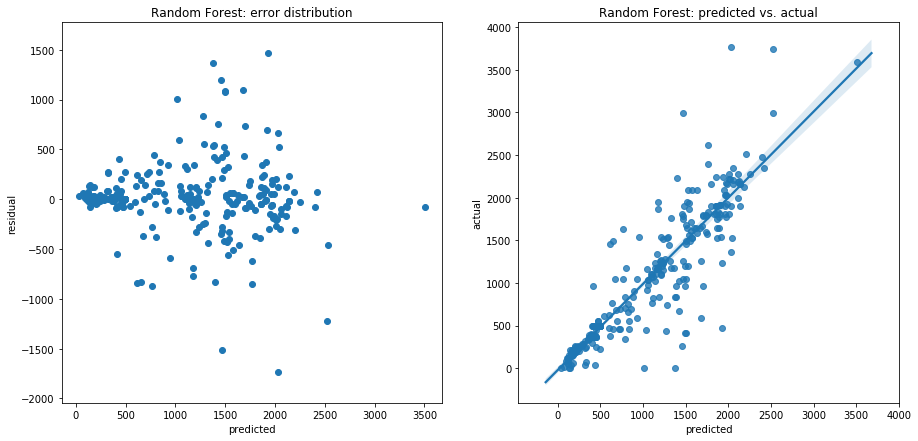

In [107]:
residual = forest_pred - y_test

plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.scatter(forest_pred,  residual)
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('residual')
plt.title('Random Forest: error distribution')

plt.subplot(122)
sns.regplot(forest_pred, y_test)
plt.axis('equal')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Random Forest: predicted vs. actual')
plt.show()

# 1 US Calorie  = 4.184 kJ

`We made our predictions in kJs, our rmse is therefore appr. 320.92 kJ (or 76.70) per 100 g. MSE is 169.22 kJ (40.44 Calories) per 100 g. The best r2 value is 0.8257. This prediction is based only on the ingredients text.`